In [7]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import librosa
import math
from datetime import datetime

import audio_functions as af
import model_functions as mf
import audio_models
import dataset
import importlib

In [28]:
importlib.reload(audio_models)

<module 'audio_models' from 'C:\\Users\\Toby\\MSc_Project\\MScFinalProject\\audio_models.py'>

In [38]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'real_imag'
    
#checkpoint = '52/52-10' #  Best U-net
checkpoint = '134/134-3'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [39]:
#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()
#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)

voice_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
voice_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
voice_phase = tf.expand_dims(voice_spec[:, :, :-1, 3], 3)

In [13]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, data_type, name='Magnitude_Model')

Creating model


In [31]:
# Build U-Net with magnitude and pahse as input and output
mixed_inp = mixed_spec[:, :, :-1, 2:4]
voice_inp = voice_spec[:, :, :-1, 2:4]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, data_type, name='Magnitude_Model')

Creating model


In [40]:
# Build U-Net with real and imaginary as input and output
mixed_inp = mixed_spec[:, :, :-1, 0:2]
voice_inp = voice_spec[:, :, :-1, 0:2]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, data_type, name='Magnitude_Model')

Creating model


In [41]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

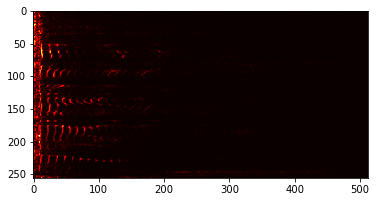

In [44]:
# Test the pipeline still works
m = sess.run(mixed_spec)

plt.imshow(m[0, :, :, 2])

complex_spec = np.empty((m.shape[1], m.shape[2]), dtype=complex)
complex_spec.real = m[0, :, :, 0]
complex_spec.imag = m[0, :, :, 1]

m_wave = librosa.istft(complex_spec.T, fft_hop)
ipd.Audio(m_wave.T, rate=sample_rate)

In [43]:
mix_mag, mix_phase, voice_mag, voice_est_mag, \
    mask, voice_wave, mix_wave, cost = sess.run([model.mixed_mag, 
                                                 model.mixed_phase, 
                                                 model.voice_mag,
                                                 model.gen_voice, 
                                                 model.voice_mask, 
                                                 model.voice_audio, 
                                                 model.mixed_audio,
                                                 model.cost],
                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

In [69]:
# For magnitude and phase
for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est_mag[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)
    

In [44]:
# For real and imaginary

complex_spec = np.empty((voice_est_mag.shape[0], voice_est_mag.shape[1], voice_est_mag.shape[2]), dtype=complex)
complex_spec.real = voice_est_mag[:, :, :, 0]
complex_spec.imag = voice_est_mag[:, :, :, 1]

for i in range(complex_spec.shape[0]):
    wave = librosa.istft(complex_spec[i].T, fft_hop)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

In [70]:
voice_est_mag.shape

(5, 256, 512, 2)

In [60]:
mix_mag.shape

(5, 256, 512, 2)

In [58]:
ipd.Audio(voice_est_wave[0].T, rate=sample_rate)

In [91]:
def l1(x, y):
    return np.mean(np.abs(x - y))

print(l1(voice_est_mag[0,:,:,0], voice_mag[0,:,:,0]))
print(cost)

4.508612e-05
0.85150206


In [93]:
def phase_loss(x, y):
    
    original_dif = np.abs(x - y)
    add_2_pi_dif = np.abs(x - (y + 2 * math.pi))
    minus_2_pi_dif = np.abs(x - (y - 2 * math.pi))

    corrected_dif = np.minimum(original_dif, np.minimum(add_2_pi_dif, minus_2_pi_dif))

    return np.mean(corrected_dif)

print(phase_loss(voice_est_mag[0,:,:,1], voice_mag[0,:,:,1]))

1.566881


In [98]:
voice_mag[0,:,:,1].min()

-3.1415927

In [97]:
2 * math.pi

6.283185307179586

In [100]:
voice_mag[0,:,:,0].max()

0.0057107

In [45]:
mag_range = voice_mag[0,:,:,0].max() - voice_mag[0,:,:,0].min()
phase_range = voice_mag[0,:,:,1].max() - voice_mag[0,:,:,1].min()
print(mag_range, '\n', phase_range)

0.0110183 
 0.009891857


In [42]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 5
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})

        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-10-30 11:25:29.518537
Epoch 0 finished. Mean cost = 1.8269366955792064e-05
Epoch 1 finished. Mean cost = 1.8253486268804407e-05
Epoch 2 finished. Mean cost = 1.824358175023614e-05
Epoch 3 finished. Mean cost = 1.823622587835416e-05
Epoch 4 finished. Mean cost = 1.8229429260827602e-05
finish: 2018-10-30 11:27:06.902644
